# Custom clustering
In this code we attempt to do custom clustering on the data. We will use the following steps:
- Preprocessing the data    
    - Get melspectogram of audio with 80 features per mel-frame. 



In [2]:
import librosa
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils_vad import (
    get_speech_timestamps,
)  # Assuming this file defines the get_speech_timestamps function
from preprocess import Wav2Mel
import torchaudio

import numpy as np
from scipy.spatial.distance import pdist, squareform


In [3]:
# Global variables used for preprocessing
SAMPLE_RATE = 16000
NORM_DB = -3
FFT_WINDOW_MS = 25
FFT_HOP_MS = 10
FRAME_SIZE = 40  # Adjust frame size if needed
BLOCK_SIZE = 50  # MFCC frames to stack together for embedding

# Path to audio file 
AUDIO_PATH = "../Dataset/Audio/Test/aggyz.wav"

In [4]:
# Load the models

# Pre-trained Dvector model --> Embedding model (modify paths as needed)
dvector_model = torch.jit.load("Pretrained Modules/dvector-step250000.pt")

# V Pretrained VAD model --> VAD model (modify paths as needed)
vad_model = torch.jit.load("Pretrained Modules/silero_vad.jit")

wave2mel = Wav2Mel(
    sample_rate=SAMPLE_RATE,
    norm_db=NORM_DB,
    fft_window_ms=FFT_WINDOW_MS,
    fft_hop_ms=FFT_HOP_MS,
    n_mels=40,
)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the dvector_model is on the GPU
dvector_model.to(device)


# In the case that you wish to verify the model architecture
#!dvector_model.eval()
#!vad_model.eval()

RecursiveScriptModule(
  original_name=AttentivePooledLSTMDvector
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (embedding): RecursiveScriptModule(original_name=Linear)
  (linear): RecursiveScriptModule(original_name=Linear)
)

In [5]:
def get_frames(mel_tensor, block_size):
    return mel_tensor.unfold(0, block_size, block_size).mT

def get_frame_embeddings(mel_frames):
    embeddings = torch.empty(mel_frames.shape[0], 256, device=device)
    for frame_idx in range(mel_frames.shape[0]):
        frame = mel_frames[frame_idx].to(device)  # Move the frame to the GPU
        embeddings[frame_idx, :] = dvector_model.embed_utterance(frame)
    return embeddings.detach().cpu().numpy()

wave_tensor_torch, wave_sampling_rate = torchaudio.load(AUDIO_PATH)
print("Shape of torch: ",wave_tensor_torch.shape)
wave_tensor, mel_tensor = wave2mel(wave_tensor_torch, wave_sampling_rate)

# Get the mel_framse and embeddings
mel_frames = get_frames(mel_tensor, BLOCK_SIZE)
embeddings = get_frame_embeddings(mel_frames)


print(mel_frames.shape)
print(embeddings.shape)


Shape of torch:  torch.Size([1, 2097113])


/tmp/ipykernel_17110/3722215312.py:8: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  embeddings[frame_idx, :] = dvector_model.embed_utterance(frame)


torch.Size([252, 50, 40])
(252, 256)


A (252, 252)
Distance (31626,)


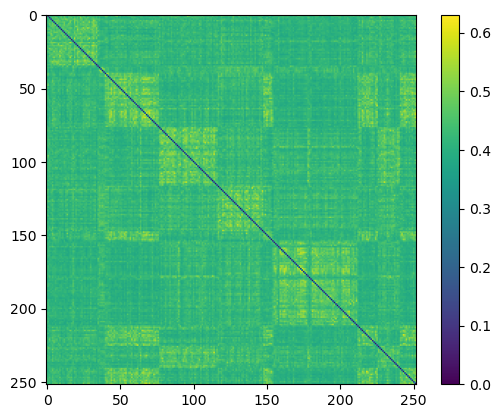

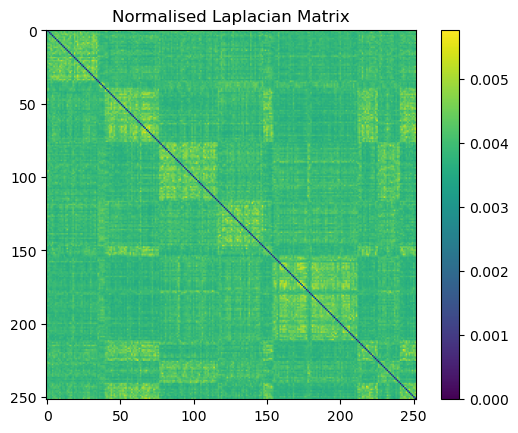

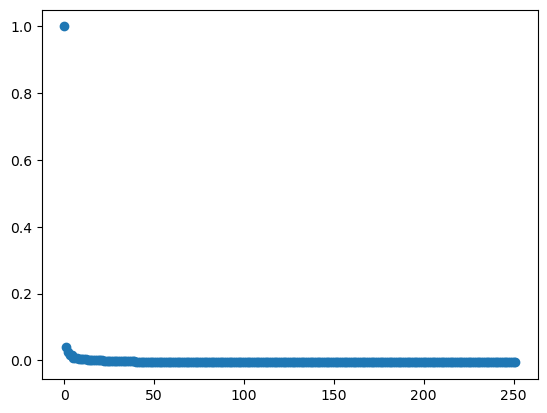

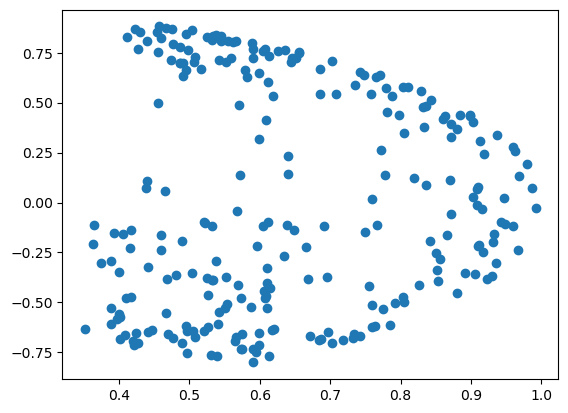

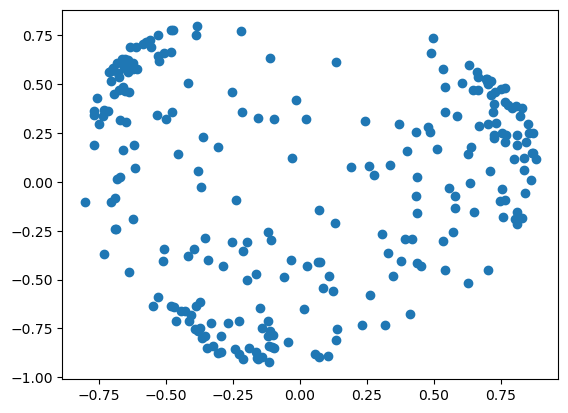

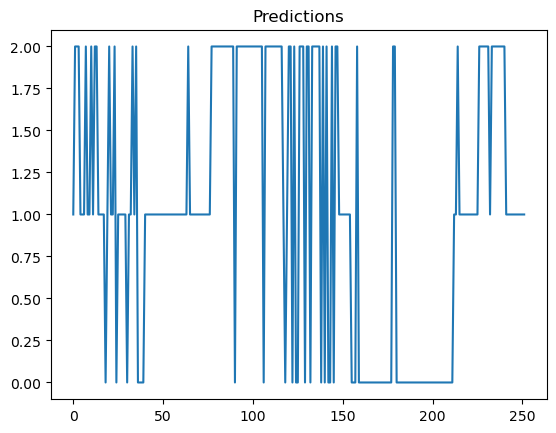

In [6]:
distance = pdist(embeddings, metric="euclidean")

A = 1 / (1 + distance)
A = squareform(A)
print("A", A.shape)
print("Distance", distance.shape)
A = A - np.diag(np.diag(A))  # set diagonal to zero
plt.imshow(A)
plt.colorbar()
plt.show()


def normalized_laplacian_matrix(A):
    # A is an adjacency matrix

    D = np.sum(A, axis=1)
    inv_sqrt_D = np.power(D, -0.5)
    L = inv_sqrt_D.reshape(-1, 1) * A * inv_sqrt_D.reshape(1, -1)

    return L


L = normalized_laplacian_matrix(A)
# Add colorbar
# Title it normalised laplacian matrix
plt.title("Normalised Laplacian Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()


w, v = np.linalg.eig(L)

eigenvalues = np.real(w)
#eigenvalues = eigenvalues[eigenvalues>0.05]
#eigenvectors = np.real(v[:, 0:len(eigenvalues)])
#print(np.diff(eigenvalues))
num_vectors = np.argmin(np.diff(eigenvalues)) + 1
num_vectors = 3
eigenvectors = np.real(v[:, 0:num_vectors])
plt.scatter(range(len(eigenvalues)), eigenvalues)
plt.show()

norm_eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)

plt.scatter(norm_eigenvectors[:, 0], norm_eigenvectors[:, 1])
plt.show()
plt.scatter(norm_eigenvectors[:, 1], norm_eigenvectors[:, 2])
plt.show()

predictions = KMeans(n_clusters=norm_eigenvectors.shape[1], n_init=5).fit_predict(norm_eigenvectors)
plt.plot(predictions)
plt.title("Predictions")
plt.show()


In [10]:
def write_rttm_file(predictions, speech_segments, filename, sampling_rate=None):
  """
  Writes speaker diarization results to an RTTM file.

  Args:
      predictions: List of predicted speaker labels for each frame.
      speech_segments: List of tuples containing (start_time, end_time) for speech segments.
      filename: Path to the output RTTM file.
      sampling_rate: Optional sampling rate of the audio (in Hz). Used for frame rate calculation if not provided elsewhere.
  """
  with open(filename, "a") as f:
    for segment_start, segment_end in speech_segments:
      # Calculate frame rate (use provided value or calculate based on global variable)
      if sampling_rate is not None:
        frame_rate = sampling_rate / FFT_HOP_MS
      else:
        global SAMPLE_RATE  # Assuming SAMPLE_RATE is defined globally
        frame_rate = SAMPLE_RATE / FFT_HOP_MS

      # Calculate frame range for the segment
      start_frame = int(segment_start * frame_rate)
      end_frame = int(segment_end * frame_rate) - 1  # Account for zero-based indexing

      # Get dominant speaker label for the segment
      speaker_label = np.argmax(np.bincount(predictions[start_frame:end_frame + 1]))

      # Create and write RTTM entry
      rttm_entry = f"SPEAKER spk{speaker_label} 1 {segment_start:.2f} {segment_end:.2f} \n"
      f.write(rttm_entry)

# Get speech segments using your get_speech_timestamps function
print("Shape of wave_tensor: ", wave_tensor.shape)
wave_tensor_torch, wave_sampling_rate = torchaudio.load(AUDIO_PATH)

# Check and potentially convert to mono
if len(wave_tensor_torch.shape) > 1:
    wave_tensor_torch = wave_tensor_torch.mean(dim=1)  # Convert to mono

speech_segments = get_speech_timestamps(wave_tensor_torch, model=vad_model)
# Write RTTM file (assuming you have sampling_rate from wave_sampling_rate)
write_rttm_file(predictions, speech_segments, "output.rttm", sampling_rate=wave_sampling_rate)

print("RTTM file generated: output.rttm")

Shape of wave_tensor:  torch.Size([12610, 40])
RTTM file generated: output.rttm
